This is the notebook to build the data processing pipeline to feed into the GRU network. It starts with a slimmed and skimmed csv file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.7.1 Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape

In [2]:
#load the data
df = pd.read_csv('../scripts/slimmed_df.csv')
df.head()

,Unnamed: 0,calib_time,integrated_oms_lumi,p2_calib,lumi-section time,int_deliv_inv_ub,int_record_inv_ub
0,0,2018-02-07 16:14:44,0.0,0.937300,2018-04-12 08:00:05,0.052346,0.0
1,1,2018-02-07 17:26:08,0.0,0.937845,2018-04-12 08:00:05,0.052346,0.0
2,2,2018-02-07 17:50:56,0.0,0.936282,2018-04-12 08:00:05,0.052346,0.0
3,3,2018-02-07 18:15:44,0.0,0.936760,2018-04-12 08:00:05,0.052346,0.0
4,4,2018-02-07 18:57:17,0.0,0.937384,2018-04-12 08:00:05,0.052346,0.0


In [3]:
df.tail()

,Unnamed: 0,calib_time,integrated_oms_lumi,p2_calib,lumi-section time,int_deliv_inv_ub,int_record_inv_ub
9212,9212,2019-01-16 15:21:50,2684.0,0.903612,2018-12-02 16:09:58,6.784826e+10,6.355219e+10
9213,9213,2019-03-13 11:27:17,2684.0,0.906701,2018-12-02 16:09:58,6.784826e+10,6.355219e+10
9214,9214,2019-03-13 11:38:30,2684.0,0.905441,2018-12-02 16:09:58,6.784826e+10,6.355219e+10
9215,9215,2019-03-13 12:16:48,2684.0,0.905441,2018-12-02 16:09:58,6.784826e+10,6.355219e+10
9216,9216,2019-03-13 12:30:42,2684.0,0.906833,2018-12-02 16:09:58,6.784826e+10,6.355219e+10


In [4]:
#now we'll select just the columns we want to study
df_slim = df.loc[:,['calib_time','p2_calib','int_deliv_inv_ub']]
#set the index to calib time
df_slim['calib_time'] = df_slim['calib_time'].astype('datetime64')
df_slim.set_index('calib_time', inplace=True)
df_slim.head()

,p2_calib,int_deliv_inv_ub
calib_time,,
2018-02-07 16:14:44,0.937300,0.052346
2018-02-07 17:26:08,0.937845,0.052346
2018-02-07 17:50:56,0.936282,0.052346
2018-02-07 18:15:44,0.936760,0.052346
2018-02-07 18:57:17,0.937384,0.052346


In [5]:
#split the data into training, testing and validating
#select the data range (we'll select the part of the year when the beam was operating)
data_begin = '2018-04-12 08:00:00'
data_end = '2018-12-02 16:00:00'

df_select = df_slim[(df_slim.index > data_begin) & (df_slim.index < data_end)]

#select the time ranges for train,valid,test datasets
df_train_end = '2018-08-31 00:00:00'
df_valid_end = '2018-10-15 00:00:00'
df_test_end = data_end

df_train = df_select[df_select.index < df_train_end]
df_valid = df_select[(df_select.index < df_valid_end) & (df_select.index > df_train_end)]
df_test = df_select[(df_select.index < df_test_end) & (df_select.index > df_valid_end)]

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


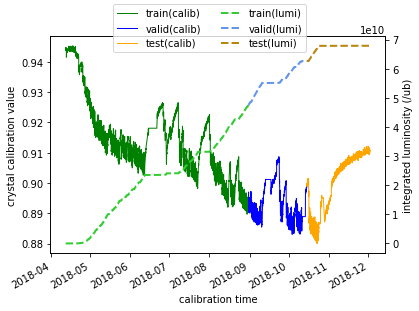

In [6]:
#now lets make a plot of our three datasets

fig, ax1 = plt.subplots()

ax1.set_ylabel('crystal calibration value')
ax1.set_xlabel('calibration time')
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_train.index, df_train.p2_calib, 
         label='train(calib)', color='green', linewidth=1, linestyle='solid')
ax1.plot(df_valid.index, df_valid.p2_calib, 
         label='valid(calib)', color='blue', linewidth=1, linestyle='solid')
ax1.plot(df_test.index, df_test.p2_calib, 
         label='test(calib)', color='orange', linewidth=1, linestyle='solid')

#lumi data on alternate y axis
ax2 = ax1.twinx()
ax2.set_ylabel('integrated luminosity (/ub)')

ax2.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='train(lumi)', color='limegreen', linewidth=2, linestyle='dashed')
ax2.plot(df_valid.index, df_valid.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax2.plot(df_test.index, df_test.int_deliv_inv_ub, 
         label='test(lumi)', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#combined legend
fig.legend(ncol=2, loc = 'upper center')

fig.show()

In [102]:
#lets look at the time spacing in the raw data
calib_timedelta = df_select.reset_index().calib_time.diff()
calib_td_mins = calib_timedelta.apply(lambda x: x.seconds/60)

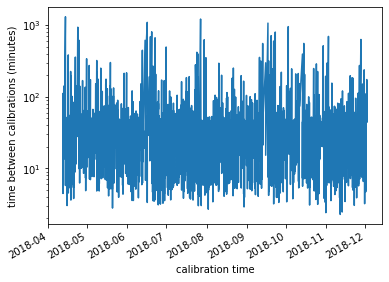

In [108]:
fig8, ax12 = plt.subplots()

ax12.set_ylabel('time between calibrations (minutes)')
ax12.set_xlabel('calibration time')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax12.set_yscale('log')

ax12.plot(df_select.index, calib_td_mins, label='calib_td')
fig8.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


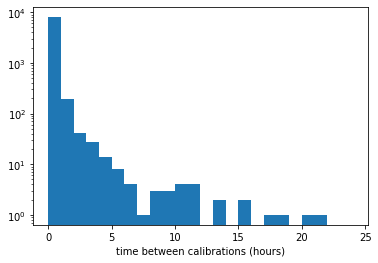

In [116]:
fig9, ax13 = plt.subplots()

calib_td_hrs = calib_timedelta.apply(lambda x: x.seconds/3600)
bins = [bin for bin in range(0, 24+1, 1)]
print(bins)
ax13.hist(calib_td_hrs, bins=bins)
ax13.set_xlabel('time between calibrations (hours)')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax13.set_yscale('log')

fig9.show()

In [7]:
#now that we've looked at the raw data, we have to do a few manipulations.
#the first is to convert the data into an evenly spaced timeseries. We'll use a rolling average
import traces as ts

#windows are in seconds
train_calib_avg = ts.TimeSeries(df_train['p2_calib'])\
                                .moving_average(3600, window_size=3600, pandas=True)
train_lumi_avg = ts.TimeSeries(df_train['int_deliv_inv_ub'])\
                                .moving_average(3600, window_size=3600, pandas=True)

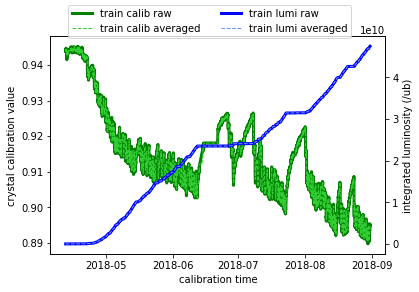

In [8]:
#lets plot the situation
fig2, ax3 = plt.subplots()

ax3.set_ylabel('crystal calibration value')
ax3.set_xlabel('calibration time')

#calibration data
ax3.plot(df_train.index, df_train.p2_calib, 
         label='train calib raw', color='green', linewidth=3, linestyle='solid')
ax3.plot(train_calib_avg.index, train_calib_avg, 
         label='train calib averaged', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax4 = ax3.twinx()
ax4.set_ylabel('integrated luminosity (/ub)')

ax4.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='train lumi raw', color='blue', linewidth=3, linestyle='solid')
ax4.plot(train_lumi_avg.index, train_lumi_avg, 
         label='train lumi averaged', color='cornflowerblue', linewidth=1, linestyle='dashed')

#combined legend
fig2.legend(ncol=2, loc = 'upper center')

fig2.show()

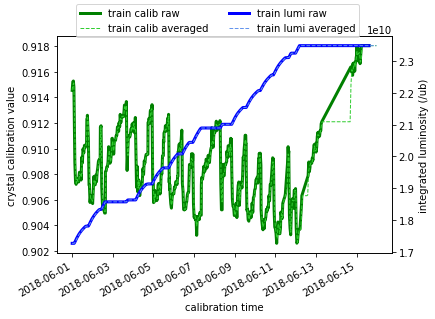

In [9]:
#lets plot a zoomed in view of the situation
fig3, ax5 = plt.subplots()

ax5.set_ylabel('crystal calibration value')
ax5.set_xlabel('calibration time')
plt.setp(ax5.get_xticklabels(), rotation=30, horizontalalignment='right')

max_time = '2018-06-16 00:00:00'
min_time = '2018-06-01 00:00:00'

df_zoom = df_train[(df_train.index < max_time) & (df_train.index > min_time)]
train_calib_avg_zoom = train_calib_avg[(train_calib_avg.index < max_time) & (train_calib_avg.index > min_time)]
train_lumi_avg_zoom = train_lumi_avg[(train_lumi_avg.index < max_time) & (train_lumi_avg.index > min_time)]

#calibration data
ax5.plot(df_zoom.index, df_zoom.p2_calib, 
         label='train calib raw', color='green', linewidth=3, linestyle='solid')
ax5.plot(train_calib_avg_zoom.index, train_calib_avg_zoom, 
         label='train calib averaged', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax6 = ax5.twinx()
ax6.set_ylabel('integrated luminosity (/ub)')

ax6.plot(df_zoom.index, df_zoom.int_deliv_inv_ub, 
         label='train lumi raw', color='blue', linewidth=3, linestyle='solid')
ax6.plot(train_lumi_avg_zoom.index, train_lumi_avg_zoom, 
         label='train lumi averaged', color='cornflowerblue', linewidth=1, linestyle='dashed')


#combined legend
fig3.legend(ncol=2, loc = 'upper center')

fig3.show()
#you can see that it isn't perfect when there are gaps in the data.
#this can be tweaked by increasing the sliding average size, but then you lose resolution
#figuring out how to run it with a variable resolution would be tricky.
#but you could also choose a different interpolation technique to try to paste over the gaps

In [10]:
#now that we've explored the interpolation and made interpolated training data,
#we'll follow the same steps for the testing and validation data
valid_calib_avg = ts.TimeSeries(df_valid['p2_calib'])\
                                .moving_average(3600, window_size=3600, pandas=True)
valid_lumi_avg = ts.TimeSeries(df_valid['int_deliv_inv_ub'])\
                                .moving_average(3600, window_size=3600, pandas=True)

test_calib_avg = ts.TimeSeries(df_test['p2_calib'])\
                                .moving_average(3600, window_size=3600, pandas=True)
test_lumi_avg = ts.TimeSeries(df_test['int_deliv_inv_ub'])\
                                .moving_average(3600, window_size=3600, pandas=True)

#now we'll put it all back into dataframes
train = pd.DataFrame()
train['p2_calib'] = train_calib_avg
train['int_deliv_inv_ub'] = train_lumi_avg

valid = pd.DataFrame()
valid['p2_calib'] = valid_calib_avg
valid['int_deliv_inv_ub'] = valid_lumi_avg

test = pd.DataFrame()
test['p2_calib'] = test_calib_avg
test['int_deliv_inv_ub'] = test_lumi_avg

In [11]:
#now we need to de-trend the data so that it is flat over time
#for this I'll just apply differencing, since it is pretty simple
train = train.diff().dropna() #we run dropna, since the first row is NaN in a diff
valid = valid.diff().dropna()
test = test.diff().dropna()

In [22]:
#now we'll scale the input data for the network
#scale values to between 0 and 1

scaler = preprocessing.MinMaxScaler()
train[['p2_calib', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
valid[['p2_calib', 'int_deliv_inv_ub']] = scaler.transform(valid)
test[['p2_calib', 'int_deliv_inv_ub']] = scaler.transform(test)

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


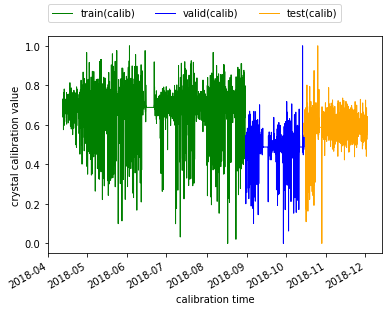

In [23]:
#lets plot the data 1 more time
fig4, ax7 = plt.subplots()

ax7.set_ylabel('crystal calibration value')
ax7.set_xlabel('calibration time')
plt.setp(ax7.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax7.plot(train.index, train.p2_calib, 
         label='train(calib)', color='green', linewidth=1, linestyle='solid')
ax7.plot(valid.index, valid.p2_calib, 
         label='valid(calib)', color='blue', linewidth=1, linestyle='solid')
ax7.plot(test.index, test.p2_calib, 
         label='test(calib)', color='orange', linewidth=1, linestyle='solid')
#legend
fig4.legend(ncol=3, loc = 'upper center')
fig4.show()

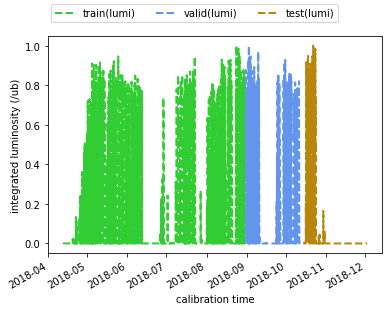

In [24]:
#lumi data on alternate y axis
fig5, ax8 = plt.subplots()
ax8.set_ylabel('integrated luminosity (/ub)')
ax8.set_xlabel('calibration time')
plt.setp(ax8.get_xticklabels(), rotation=30, horizontalalignment='right')

ax8.plot(train.index, train.int_deliv_inv_ub, 
         label='train(lumi)', color='limegreen', linewidth=2, linestyle='dashed')
ax8.plot(valid.index, valid.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax8.plot(test.index, test.int_deliv_inv_ub, 
         label='test(lumi)', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#legend
fig5.legend(ncol=3, loc = 'upper center')
fig5.show()

In [73]:
#number of lag variables and horizon (these are just some starting choices)
T = 24 #the past N hours to study
HORIZON = 1 #predict the next N hours

#sample tensor structure
tensor_structure = {'X':(range(-T+1, 1), ['p2_calib', 'int_deliv_inv_ub'])}

#training tensor
train_input = TimeSeriesTensor(
    dataset=train,
    target="p2_calib",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H", #hours
    drop_incomplete=True, #for some reason the data is very sparse
)

#validation tensor
valid_inputs = TimeSeriesTensor(valid, "p2_calib", HORIZON, tensor_structure)

In [74]:
#now we bring in the keras tensorflow model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [75]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [76]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 5)                 135       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [79]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [80]:
model_history = model.fit(
    train_input["X"],
    train_input["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
105/105 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0392
Epoch 2/50
105/105 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0417
Epoch 3/50
105/105 [==============================] - 1s 12ms/step - loss: 0.0075 - val_loss: 0.0385
Epoch 4/50
105/105 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 0.0407
Epoch 5/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0075 - val_loss: 0.0397
Epoch 6/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0075 - val_loss: 0.0370
Epoch 7/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0075 - val_loss: 0.0413
Epoch 8/50
105/105 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0381
Epoch 9/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0074 - val_loss: 0.0385
Epoch 10/50
105/105 [==============================] - 1s 9ms/step - loss: 0.0074 - val_loss: 0

In [81]:
#now we'll test
data_test_inputs = TimeSeriesTensor(test, "p2_calib", HORIZON, tensor_structure)

predictions = model.predict(data_test_inputs["X"])

ev_data = create_evaluation_df(predictions, data_test_inputs, HORIZON, scaler)
ev_data.head()

,timestamp,h,prediction,actual
0,2018-10-16 00:27:23,t+1,0.668138,0.572963
1,2018-10-16 01:27:23,t+1,0.658983,0.617926
2,2018-10-16 02:27:23,t+1,0.671676,0.592673
3,2018-10-16 03:27:23,t+1,0.661523,0.520189
4,2018-10-16 04:27:23,t+1,0.646896,0.650007


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


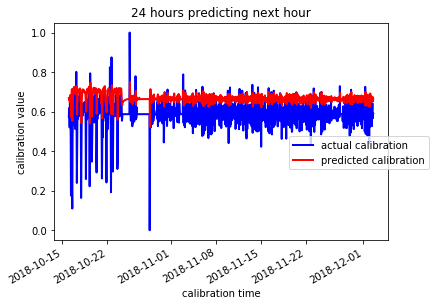

In [82]:
#lets plot our results
fig6, ax9 = plt.subplots()

ax9.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax9.set_ylabel('calibration value')
ax9.set_xlabel('calibration time')
plt.setp(ax9.get_xticklabels(), rotation=30, horizontalalignment='right')

ax9.plot(ev_data.timestamp, ev_data.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax9.plot(ev_data.timestamp, ev_data.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')
#legend
fig6.legend(ncol=1, loc = 'right')
fig6.show()

In [83]:
#now we'll look at zoomed in view
start = '2018-11-15 00:00:00'
stop = '2018-11-16 00:00:00'

ev_data = ev_data[( (ev_data.timestamp > start) & (ev_data.timestamp < stop) )]

ev_lumi = test_lumi_avg[( (test_lumi_avg.index > start) & (test_lumi_avg.index < stop) )]

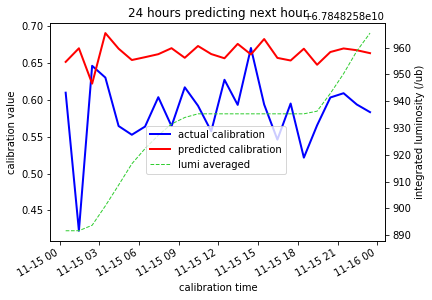

In [84]:
#lets plot our results
fig7, ax10 = plt.subplots()

ax10.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax10.set_ylabel('calibration value')
ax10.set_xlabel('calibration time')
plt.setp(ax10.get_xticklabels(), rotation=30, horizontalalignment='right')

ax10.plot(ev_data.timestamp, ev_data.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax10.plot(ev_data.timestamp, ev_data.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')

#lumi data on alternate y axis
ax11 = ax10.twinx()
ax11.set_ylabel('integrated luminosity (/ub)')

ax11.plot(ev_lumi.index, ev_lumi, 
         label='lumi averaged', color='limegreen', linewidth=1, linestyle='dashed')

#legend
fig7.legend(ncol=1, loc='center')
fig7.show()

In [117]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

NameError: name 'ev_ts_data' is not defined